In [1]:
import IJulia

# The julia kernel has built in support for Revise.jl, so this is the 
# recommended approach for long-running sessions:
# https://github.com/JuliaLang/IJulia.jl/blob/9b10fa9b879574bbf720f5285029e07758e50a5e/src/kernel.jl#L46-L51

# Users should enable revise within .julia/config/startup_ijulia.jl:
# https://timholy.github.io/Revise.jl/stable/config/#Using-Revise-automatically-within-Jupyter/IJulia-1

# clear console history
IJulia.clear_history()

fig_width = 7
fig_height = 5
fig_format = :retina
fig_dpi = 96

# no retina format type, use svg for high quality type/marks
if fig_format == :retina
  fig_format = :svg
elseif fig_format == :pdf
  fig_dpi = 96
  # Enable PDF support for IJulia
  IJulia.register_mime(MIME("application/pdf"))
end

# convert inches to pixels
fig_width = fig_width * fig_dpi
fig_height = fig_height * fig_dpi

# Intialize Plots w/ default fig width/height
try
  import Plots

  # Plots.jl doesn't support PDF output for versions < 1.28.1
  # so use png (if the DPI remains the default of 300 then set to 96)
  if (Plots._current_plots_version < v"1.28.1") & (fig_format == :pdf)
    Plots.gr(size=(fig_width, fig_height), fmt = :png, dpi = fig_dpi)
  else
    Plots.gr(size=(fig_width, fig_height), fmt = fig_format, dpi = fig_dpi)
  end
catch e
  # @warn "Plots init" exception=(e, catch_backtrace())
end

# Initialize CairoMakie with default fig width/height
try
  import CairoMakie

  # CairoMakie's display() in PDF format opens an interactive window
  # instead of saving to the ipynb file, so we don't do that.
  # https://github.com/quarto-dev/quarto-cli/issues/7548
  if fig_format == :pdf
    CairoMakie.activate!(type = "png")
  else
    CairoMakie.activate!(type = string(fig_format))
  end
  CairoMakie.update_theme!(resolution=(fig_width, fig_height))
catch e
    # @warn "CairoMakie init" exception=(e, catch_backtrace())
end
  
# Set run_path if specified
try
  run_path = raw"/Users/hirofumi48/162348.github.io/posts/2025/PDMP"
  if !isempty(run_path)
    cd(run_path)
  end
catch e
  @warn "Run path init:" exception=(e, catch_backtrace())
end


# emulate old Pkg.installed beahvior, see
# https://discourse.julialang.org/t/how-to-use-pkg-dependencies-instead-of-pkg-installed/36416/9
import Pkg
function isinstalled(pkg::String)
  any(x -> x.name == pkg && x.is_direct_dep, values(Pkg.dependencies()))
end

# ojs_define
if isinstalled("JSON") && isinstalled("DataFrames")
  import JSON, DataFrames
  global function ojs_define(; kwargs...)
    convert(x) = x
    convert(x::DataFrames.AbstractDataFrame) = Tables.rows(x)
    content = Dict("contents" => [Dict("name" => k, "value" => convert(v)) for (k, v) in kwargs])
    tag = "<script type='ojs-define'>$(JSON.json(content))</script>"
    IJulia.display(MIME("text/html"), tag)
  end
elseif isinstalled("JSON")
  import JSON
  global function ojs_define(; kwargs...)
    content = Dict("contents" => [Dict("name" => k, "value" => v) for (k, v) in kwargs])
    tag = "<script type='ojs-define'>$(JSON.json(content))</script>"
    IJulia.display(MIME("text/html"), tag)
  end
else
  global function ojs_define(; kwargs...)
    @warn "JSON package not available. Please install the JSON.jl package to use ojs_define."
  end
end


# don't return kernel dependencies (b/c Revise should take care of dependencies)
nothing


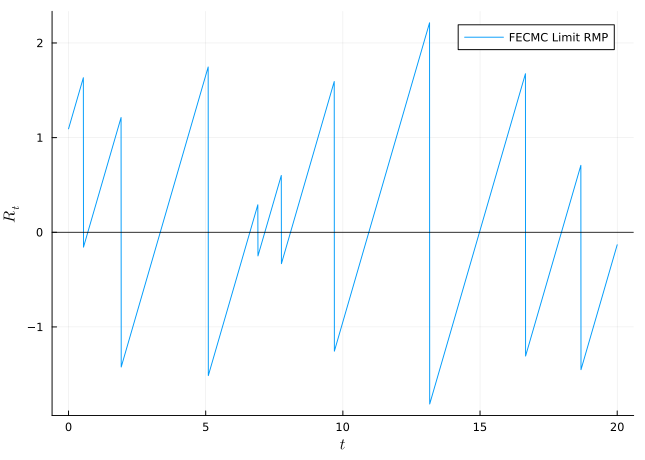

In [2]:
using Random, Distributions, Plots, LaTeXStrings

function SimulateSkeleton(x₀; T::Float64=20.0, seed::Int=0)
  if seed == 0
    τ = () -> rand(Rayleigh(1.0))
  else
    rng = MersenneTwister(seed)
    τ = () -> rand(rng, Rayleigh(1.0))
  end

  if x₀ <= 0
    tₑ = -x₀ + τ()
  else
    if seed == 0
      tₑ = -x₀ + sqrt(x₀^2 - 2log(1-rand()))
    else
      tₑ = -x₀ + sqrt(x₀^2 - 2log(1-rand(rng)))
    end
  end

  skeletons = [0.0, tₑ]
  positions = [x₀]

  while tₑ < T
    τ₁, τ₂ = τ(), τ()
    tₑ += τ₁ + τ₂
    push!(skeletons, tₑ)
    push!(positions, -τ₁)
  end

  return skeletons[1:end-1], positions
end

function DiscretizeSkeleton(skeletons::Vector{Float64}, positions::Vector{Float64}; dt::Float64=0.005, T::Float64=10.0)

  tᵢ = 0.0:dt:T
  i = searchsortedfirst.(Ref(skeletons), tᵢ) .- 1
  i[1] = 1
  flow = (x,t) -> x + t
  locate = (j,t) -> flow(positions[j], t - skeletons[j])
  samples = [locate(j, t) for (j, t) in zip(i, tᵢ)]

  return tᵢ, samples
end

function sample(x₀::Float64; T::Float64=10.0, seed::Int=0, dt::Float64=0.005)

  skeletons, positions = SimulateSkeleton(x₀, seed=seed)
  tᵢ, samples = DiscretizeSkeleton(skeletons, positions, dt=dt, T=T)
end

plot(sample(randn(), T=20.0), xlabel=L"t", ylabel=L"R_t", label="FECMC Limit RMP") |> q -> hline!(q, [0], linewidth=0.8, color=:black, label="")

0.4072281687098688

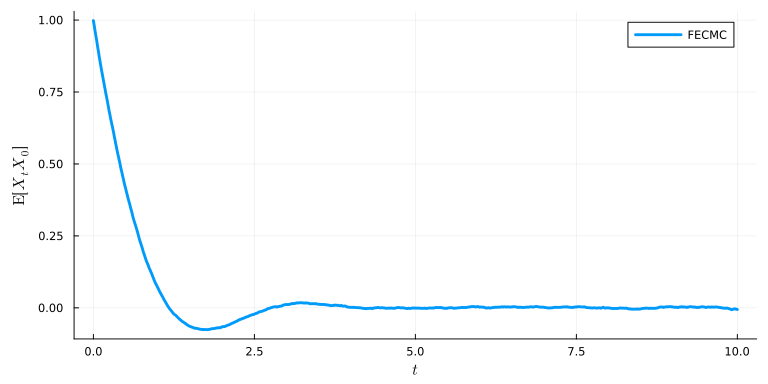

In [3]:
function calc_covariance(N::Int=10^5; seed::Int=0)
  t, x = sample(0.0, seed=seed)
  ρₙ = Matrix{Float64}(undef, N, length(t))

  for i in 1:N
    x₀ = randn()
    t, x = sample(x₀, seed=seed)
    ρₙ[i, :] = x₀ * x
  end

  return t, mean(ρₙ, dims=1)[:]
end

t, m = calc_covariance()

print(sum(m) * step(t))
p = plot(t, m, xlabel=L"t", ylabel=L"\operatorname{E}[X_tX_0]", label="FECMC", linewidth=3, size=(800, 400), left_margin=5Plots.mm, bottom_margin=3Plots.mm)
p

In [4]:
function calc_ρ0(N::Int=10)
  MCEstimates = Vector{Float64}(undef, N)
  for i in 1:10
    t, m = calc_covariance()
    MCEstimates[i] = sum(m) * step(t)
  end
  return mean(MCEstimates), std(MCEstimates)
end
m, σ = calc_ρ0()
print("Monte Carlo estimate: $(m) ± $(σ)")

Monte Carlo estimate: 0.3936535501308384 ± 0.012060598826443033

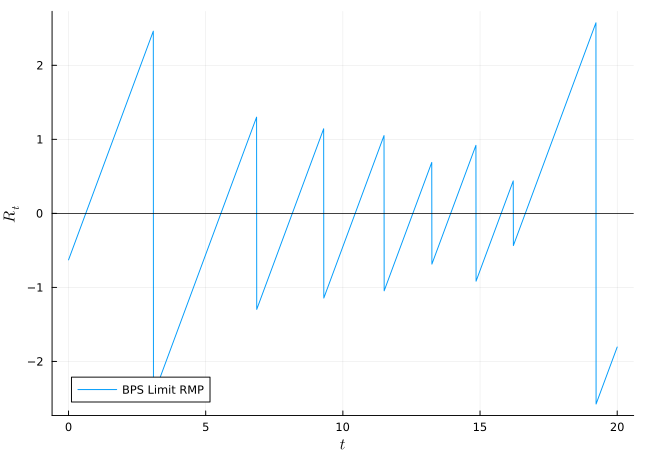

In [5]:
function SimulateBPSSkeleton(x₀; T::Float64=20.0, seed::Int=0)

  if seed == 0
    τ = () -> rand(Rayleigh(1.0))
  else
    rng = MersenneTwister(seed)
    τ = () -> rand(rng, Rayleigh(1.0))
  end

  if x₀ <= 0
    tₑ = -x₀ + τ()
  else
    if seed == 0
      tₑ = -x₀ + sqrt(x₀^2 - 2log(1-rand()))
    else
      tₑ = -x₀ + sqrt(x₀^2 - 2log(1-rand(rng)))
    end
  end

  skeletons = [0.0, tₑ]
  positions = [x₀, - (x₀ + tₑ)]

  while tₑ < T
    τ₁ = τ()
    tₑ += -positions[end] + τ₁
    push!(skeletons, tₑ)
    push!(positions, -τ₁)
  end

  return skeletons[1:end-1], positions
end

function sampleBPS(x₀::Float64; seed::Int=0, T::Float64=10.0, dt::Float64=0.005)

  skeletons, positions = SimulateBPSSkeleton(x₀, seed=seed)
  tᵢ, samples = DiscretizeSkeleton(skeletons, positions, dt=dt, T=T)
end

plot(sampleBPS(randn(), T=20.0), xlabel=L"t", ylabel=L"R_t", label="BPS Limit RMP") |> q -> hline!(q, [0], linewidth=0.8, color=:black, label="")

0.002523829543302953

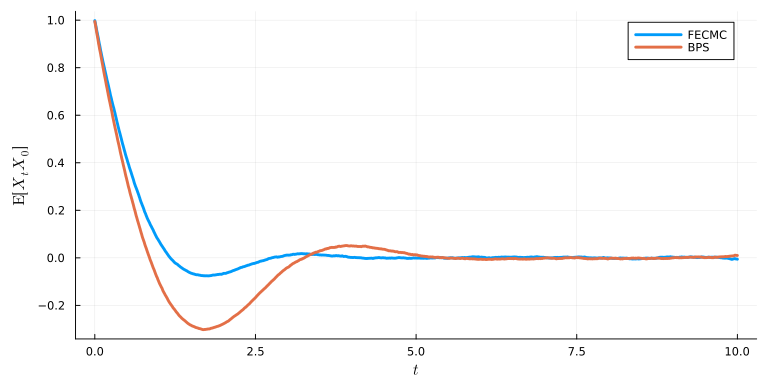

In [6]:
function calc_BPS_Covariance(N::Int=10^5; seed::Int=0)
  t, x = sampleBPS(0.0, seed=seed)
  ρₙ = Matrix{Float64}(undef, N, length(t))

  for i in 1:N
    x₀ = randn()
    t, x = sampleBPS(x₀, seed=seed)
    ρₙ[i, :] = x₀ * x
  end

  return t, mean(ρₙ, dims=1)[:]
end

t, m = calc_BPS_Covariance()

print(sum(m) * step(t))

plot!(p, t, m, xlabel=L"t", ylabel=L"\operatorname{E}[X_tX_0]", label="BPS", linewidth=3, left_margin=5Plots.mm, bottom_margin=3Plots.mm)

In [7]:
function calc_ρ_truncated(T::Float64=10.0, N::Int=10^5, seed::Int=0)
  σ²_truncated = Vector{Float64}(undef, N)

  for i in 1:N
    x₀ = randn()
    t, x = sampleBPS(x₀, seed=seed, T=T)
    σ²_truncated[i] = x₀^2 * x₀
  end

  return mean(σ²_truncated)/2
end

println(calc_ρ_truncated())

0.00585462476837008


In [8]:
function calc_ρ_truncated2(T::Float64=10.0, N::Int=10^5, seed::Int=0)
  σ²_truncated = Vector{Float64}(undef, N)

  for i in 1:N
    x₀ = randn()
    t, x = sampleBPS(x₀, seed=seed, T=T)
    integralX = sum(x) * step(t)
    σ²_truncated[i] = integralX * x₀
  end

  return mean(σ²_truncated)/2
end

println(calc_ρ_truncated2())

0.007421467097262647


In [9]:
function calc_minimum_covariance(T::Float64=2.0, N::Int=10^5, seed::Int=0)
  minimum_covariance = Vector{Float64}(undef, N)

  for i in 1:N
    x₀ = randn()
    t, x = sampleBPS(x₀, seed=seed, T=T)
    minimum_covariance[i] = x₀ * x[end]
  end

  return mean(minimum_covariance)
end

function examine_MC_variance(N::Int=100)
  MCEstimates = Vector{Float64}(undef, N)
  for i in 1:N
    MCEstimates[i] = calc_minimum_covariance()
  end
  return MCEstimates
end

calc_minimum_covariance()

-0.27939913563696356

In [10]:
function calc_small_covariance(δ::Float64=0.05, T::Float64=0.1, N::Int=10^5, seed::Int=0, dt=10^(-4))
  small_covariance = Vector{Float64}(undef, N)

  for i in 1:N
    x₀ = randn()
    t, x = sampleBPS(x₀, seed=seed, T=T, dt=dt)
    index = searchsortedfirst(t,δ)
    if t[index] != δ
      raise(IndexError, "Index error: δ is not found in the time series")
    end
    small_covariance[i] = x₀ * x[index]
  end

  theMean = mean(small_covariance)

  return theMean, (theMean - 1) / δ
end

small_covariance, derivative = calc_small_covariance()
println(small_covariance)
println("The derivative at 0 is $(derivative), which shoud be: ", -2 * sqrt(2/π))

0.9120207297120115


The derivative at 0 is -1.7595854057597693, which shoud be: -1.5957691216057308
